## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
if data['sex'].dtype == "object":
  print('her')

her


In [11]:
vars_num = [col for col in data.columns if data[col].dtype != "object"]# fill your code here

vars_cat = [col for col in data.columns if data[col].dtype == "object"] # fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables
print(data[vars_num].isnull().sum())


pclass        0
survived      0
age         263
sibsp         0
parch         0
fare          1
dtype: int64


In [13]:
# now in categorical variables
data[vars_cat].isnull().sum()


sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine cardinality of categorical variables

In [14]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

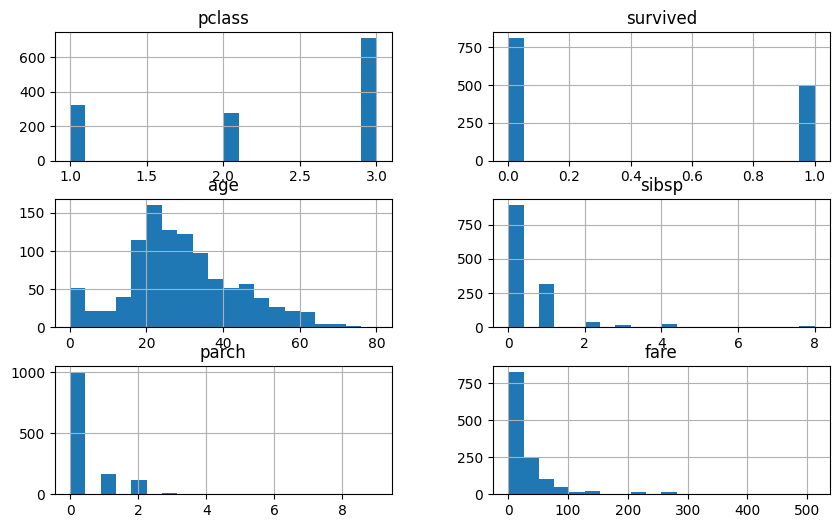

In [15]:
data.hist(bins = 20 , figsize = (10 , 6))
plt.show()


## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [22]:
# data.drop(['survived'] , axis = 1 , inplace = True)
# vars_num.remove('survived')
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin']

In [23]:
import re
def regex_cabin(row):
  if pd.isna(row):
    return np.nan
  else:
    # print(row)
    a = re.findall(r'[0-9]+' , str(row))
    # print(a)
    return float(a[0]) if a else np.nan

data['cabin'] = data['cabin'].apply(regex_cabin)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [24]:
vars_num = vars_num + ['cabin']
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'cabin']

In [25]:
data['cabin'].dtypes

dtype('float64')

In [26]:
for col in vars_num:
  data[col] = data[col].fillna(data[col].median())

### Replace Missing data in categorical variables with the string **Missing**

In [27]:
vars_cat.remove('cabin')
vars_cat

['sex', 'embarked', 'title']

In [28]:
for col in vars_cat:
  data[col] = data[col].fillna("Missing")

In [29]:
data.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
dtype: int64

In [30]:
data.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title'],
      dtype='object')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [31]:
# data.drop(['cabin'] , axis =1 , inplace = True)
# data.rename({'cabin_letter' : 'cabin'} , axis =1  , inplace = True)

In [32]:
# vars_cat = ['sex', 'embarked', 'title']

In [33]:
for col in vars_cat:
  # print(data[col].value_counts()['male'])
  # print(data[col].unique())
  for val in data[col].unique():
    if (data[col].value_counts()[val] / data[col].value_counts().sum()) * 100 < 5:
      print(col , val)
      print((data[col].value_counts()[val] / data[col].value_counts().sum()) * 100)
      data[col] = data[col].replace(str(val) , "Missing")

embarked Missing
0.15278838808250572
title Master
4.660045836516425
title Other
2.3682200152788386


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [34]:
data.head(5)

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,5.0,S,Miss
1,1,1,male,0.9167,1,2,151.5500,22.0,S,Missing
2,1,0,female,2.0000,1,2,151.5500,22.0,S,Miss
3,1,0,male,30.0000,1,2,151.5500,22.0,S,Mr
4,1,0,female,25.0000,1,2,151.5500,22.0,S,Mrs


In [35]:
data.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title'],
      dtype='object')

In [36]:
new_data = pd.get_dummies(data , columns = vars_cat , drop_first=True)
new_data.head(3)

,pclass,survived,age,sibsp,parch,fare,cabin,sex_male,embarked_Missing,embarked_Q,embarked_S,title_Missing,title_Mr,title_Mrs
0,1,1,29.0000,0,0,211.3375,5.0,0,0,0,1,0,0,0
1,1,1,0.9167,1,2,151.5500,22.0,1,0,0,1,1,0,0
2,1,0,2.0000,1,2,151.5500,22.0,0,0,0,1,0,0,0


In [37]:
new_data.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'sex_male', 'embarked_Missing', 'embarked_Q', 'embarked_S',
       'title_Missing', 'title_Mr', 'title_Mrs'],
      dtype='object')

### Scale the variables

- Use the standard scaler from Scikit-learn

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    new_data.drop('survived', axis=1),  # predictors
    new_data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 13), (262, 13))

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_train[0]

array([ 0.83580798, -0.37016209, -0.47891102, -0.45542335, -0.50478215,
       -0.12722252,  0.76104239, -0.04374786, -0.31953914,  0.63964997,
       -0.27577789,  0.86989161, -0.43562912])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0 , C = 0.0005)
clf.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [42]:
# Prediction
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

Logistic Regression model accuracy (in %): 67.17557251908397


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

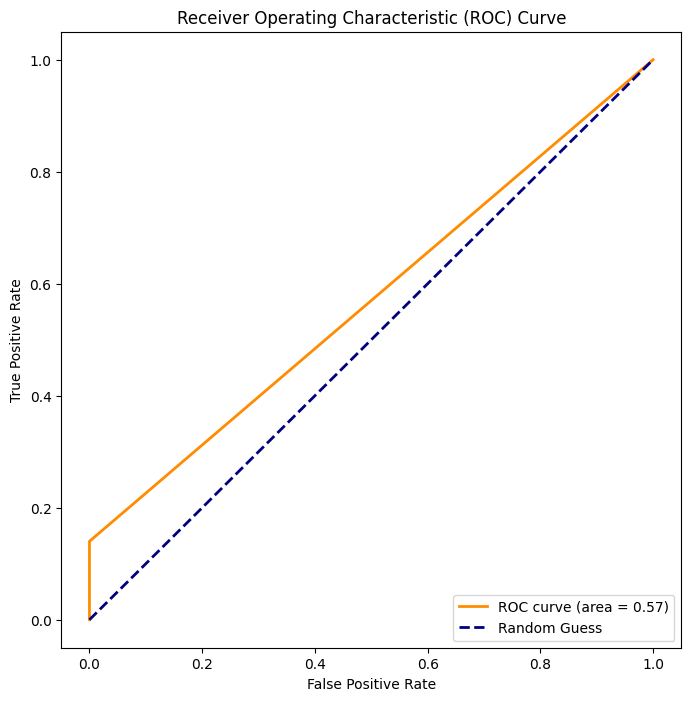

In [46]:
from sklearn.metrics import roc_curve , auc
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()